In [44]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest
from functions import load_and_merge_data, clean_data, calculate_stat_metrics, calculate_completion_rate, perform_chi2_test, calculate_time_spent, age_category,average_time_spent_by_step, time_correlation, bal_category, tenure_category

# --- Load Data ---
df = load_and_merge_data('df_final_demo.txt', 'df_final_experiment_clients.txt', 'df_final_web_data_pt_1.txt', 'df_final_web_data_pt_2.txt')
warnings.simplefilter("ignore")
df.head()
df = clean_data(df)

## Identificación cliente principal

In [45]:
df.to_csv('df_clean.csv')

<Axes: xlabel='clnt_age', ylabel='Count'>

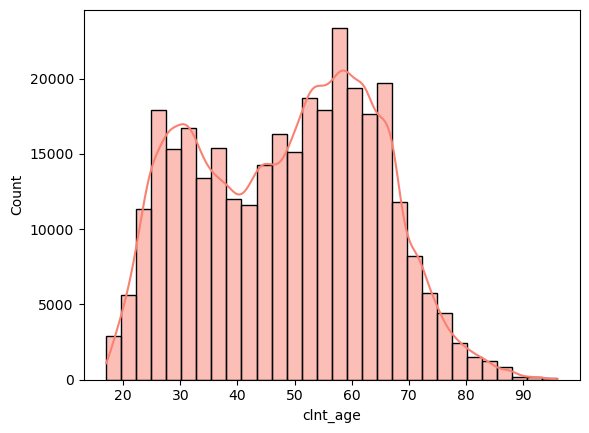

In [46]:
sns.histplot(df['clnt_age'], kde=True, bins=30, color="salmon")

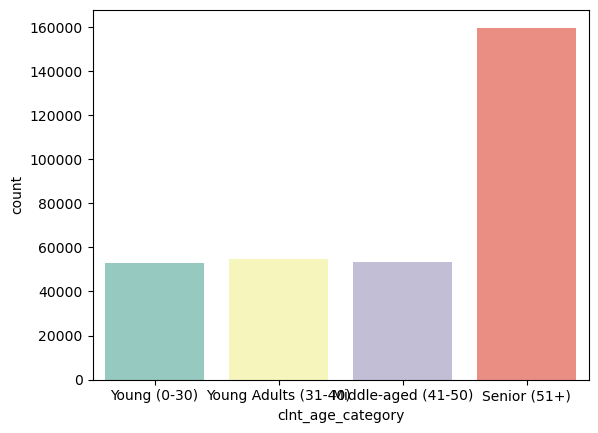

In [47]:
df = age_category(df)
sns.countplot(data=df, x='clnt_age_category', palette="Set3");

In [48]:
age_stat_metrics = calculate_stat_metrics(df, 'clnt_age')
age_stat_metrics

{'mean': 48.553511106959945,
 'median': 50.0,
 'mode': 58.5,
 'variance': 244.78442943468343,
 'std_dev': 15.64558817797156,
 'min': 17.0,
 'max': 96.0,
 'range': 79.0,
 'quartiles': 0.25    34.5
 0.50    50.0
 0.75    61.0
 Name: clnt_age, dtype: float64,
 'skewness': -0.012801806342837257,
 'kurtosis': -0.9346229222661635}

<Axes: xlabel='clnt_tenure_mnth', ylabel='Count'>

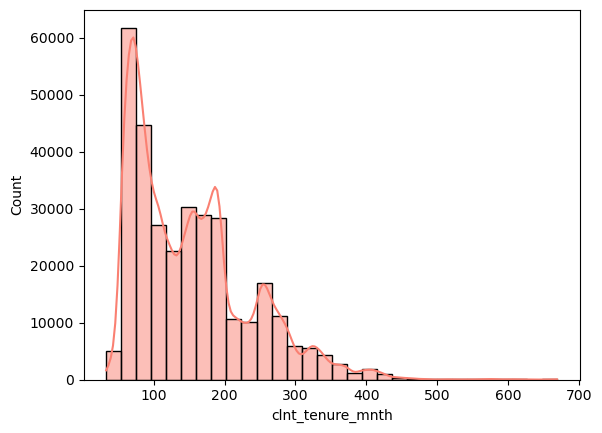

In [49]:

sns.histplot(df['clnt_tenure_mnth'], kde=True, bins=30, color="salmon")


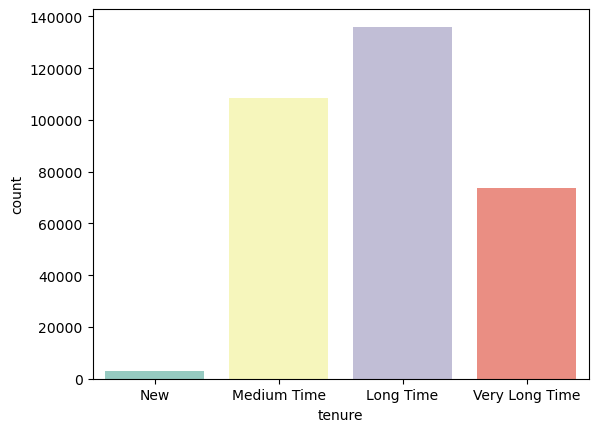

In [50]:
df = tenure_category(df)
sns.countplot(data=df, x='tenure', palette="Set3");

In [51]:
tenure_stat_metrics = calculate_stat_metrics(df, 'clnt_tenure_mnth')
tenure_stat_metrics

{'mean': 152.1330948578331,
 'median': 138.0,
 'mode': 58.0,
 'variance': 6923.801843868268,
 'std_dev': 83.20938555156064,
 'min': 33.0,
 'max': 669.0,
 'range': 636.0,
 'quartiles': 0.25     82.0
 0.50    138.0
 0.75    193.0
 Name: clnt_tenure_mnth, dtype: float64,
 'skewness': 1.0150181375795928,
 'kurtosis': 0.8901950276152149}

<Axes: xlabel='balance', ylabel='count'>

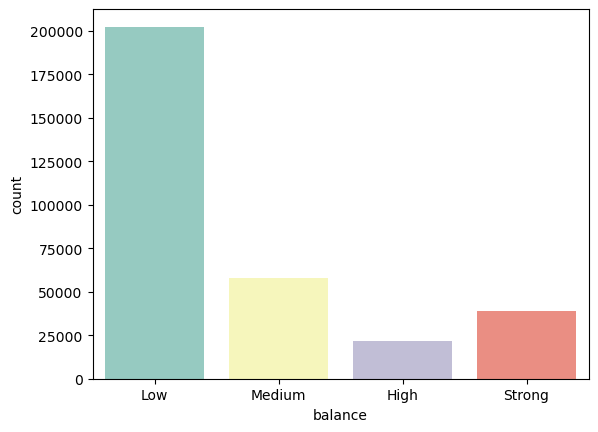

In [52]:
df = bal_category(df)
sns.countplot(data=df, x='balance', palette="Set3")

In [53]:
bal_stat_metrics = calculate_stat_metrics(df, 'bal')
bal_stat_metrics

{'mean': 162209.73110119012,
 'median': 69240.48999999999,
 'mode': 78389.93,
 'variance': 122130591740.14876,
 'std_dev': 349471.87546374707,
 'min': 23789.44,
 'max': 16320040.15,
 'range': 16296250.71,
 'quartiles': 0.25     41058.87
 0.50     69240.49
 0.75    151492.97
 Name: bal, dtype: float64,
 'skewness': 15.200960586814569,
 'kurtosis': 499.64603186135156}

### CLIENTE PRINCIPAL
- Rango de 51 años o más
- Antigüedad de mas de 8 años
- Balance bajo 

# KPI'S

In [54]:
# Determine how many users reached the "confirm" step for each variation
completion_counts = df.groupby('Variation')['process_step'].apply(lambda x: (x == 'confirm').sum()) # Funcion to count the number of users who reached the "confirm" step 
print(f'Completion Confirm Counts:\n{completion_counts}') # Print the completion_counts
completion_counts.to_csv('completion_counts.csv')

Completion Confirm Counts:
Variation
Control    17505
Test       25722
Name: process_step, dtype: int64


In [55]:
total_counts = df['Variation'].value_counts()
completion_rate = completion_counts / total_counts # Calculate the completion rate for each variation
print(f'Completion Rates:\n{completion_rate}')
completion_rate.to_csv('completion_rate.csv')

Completion Rates:
Variation
Control    0.122018
Test       0.144630
dtype: float64


In [56]:
# Analize the time spent in each step
df = df.sort_values(by=['visitor_id', 'date_time'])
# Calculate time spent on each step
df['time_spent'] = df.groupby('visitor_id')['date_time'].diff().dt.total_seconds().fillna(0)

# Average time spent on each step by variation
avg_time_spent = df.groupby(['Variation', 'process_step'])['time_spent'].mean().unstack()
print(f'Average Time Spent:\n{avg_time_spent}')
avg_time_spent.to_csv('avg_time_spent.csv')

Average Time Spent:
process_step       confirm          start      step_1     step_2      step_3
Variation                                                                   
Control       47187.336932  116308.852336  865.509168  39.387314  346.388594
Test          70075.646217   91382.160800  947.692556  83.501436  555.105314


In [57]:
session_duration = df.groupby('visitor_id').agg(
    session_start=('date_time', 'min'),
    session_end=('date_time', 'max')
).reset_index()

# Calculate duration in seconds
session_duration['duration'] = (session_duration['session_end'] - session_duration['session_start']).dt.total_seconds()

# Merge back with original data to get variation
session_duration = session_duration.merge(df[['visitor_id', 'Variation', 'process_step', 'clnt_age_category', 'time_spent']], on='visitor_id', how='left')
session_duration.to_csv('session_duration.csv')
session_duration.head()

,visitor_id,session_start,session_end,duration,Variation,process_step,clnt_age_category,time_spent
0,100019786_4272121951,2017-04-15 15:13:33,2017-04-15 15:16:47,194.0,Test,start,Middle-aged (41-50),0.0
1,100019786_4272121951,2017-04-15 15:13:33,2017-04-15 15:16:47,194.0,Test,step_1,Middle-aged (41-50),13.0
2,100019786_4272121951,2017-04-15 15:13:33,2017-04-15 15:16:47,194.0,Test,step_2,Middle-aged (41-50),35.0
3,100019786_4272121951,2017-04-15 15:13:33,2017-04-15 15:16:47,194.0,Test,step_3,Middle-aged (41-50),89.0
4,100019786_4272121951,2017-04-15 15:13:33,2017-04-15 15:16:47,194.0,Test,confirm,Middle-aged (41-50),28.0


In [58]:
# Calculate KPIs by demographic segments
segmented_kpis = session_duration.groupby('clnt_age_category').agg(
    completion_rate=('process_step', lambda x: (x == 'confirm').sum() / len(x)),
    average_session_duration=('duration', 'mean'),
    average_time_spent=('time_spent', 'mean')  
).reset_index()

# save segmented kpis as csv
segmented_kpis.to_csv('segmented_kpis.csv')
print(segmented_kpis)

      clnt_age_category  completion_rate  average_session_duration  \
0          Young (0-30)         0.138639             247880.547488   
1  Young Adults (31-40)         0.141831             270963.421864   
2   Middle-aged (41-50)         0.137977             340022.297855   
3          Senior (51+)         0.129528             569687.812440   

   average_time_spent  
0        27436.736630  
1        30324.958990  
2        36212.907187  
3        52276.527836  


In [59]:
display(df)

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation,visitor_id,visit_id,process_step,date_time,clnt_age_category,tenure,balance,time_spent
45124,6265388,7.0,94.0,42.5,U,4.0,214896.6,5.0,8.0,Test,100019786_4272121951,703380671_89376183829_330646,start,2017-04-15 15:13:33,Middle-aged (41-50),Medium Time,High,0.0
45125,6265388,7.0,94.0,42.5,U,4.0,214896.6,5.0,8.0,Test,100019786_4272121951,703380671_89376183829_330646,step_1,2017-04-15 15:13:46,Middle-aged (41-50),Medium Time,High,13.0
45126,6265388,7.0,94.0,42.5,U,4.0,214896.6,5.0,8.0,Test,100019786_4272121951,703380671_89376183829_330646,step_2,2017-04-15 15:14:21,Middle-aged (41-50),Medium Time,High,35.0
45127,6265388,7.0,94.0,42.5,U,4.0,214896.6,5.0,8.0,Test,100019786_4272121951,703380671_89376183829_330646,step_3,2017-04-15 15:15:50,Middle-aged (41-50),Medium Time,High,89.0
45128,6265388,7.0,94.0,42.5,U,4.0,214896.6,5.0,8.0,Test,100019786_4272121951,703380671_89376183829_330646,confirm,2017-04-15 15:16:18,Middle-aged (41-50),Medium Time,High,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104961,7042750,14.0,178.0,67.5,M,2.0,108406.1,4.0,7.0,Control,999998529_89539814462,583327415_19513940564_488564,step_2,2017-04-12 11:55:05,Senior (51+),Long Time,Medium,174.0
104962,7042750,14.0,178.0,67.5,M,2.0,108406.1,4.0,7.0,Control,999998529_89539814462,583327415_19513940564_488564,step_3,2017-04-12 11:55:13,Senior (51+),Long Time,Medium,8.0
104965,7042750,14.0,178.0,67.5,M,2.0,108406.1,4.0,7.0,Control,999998529_89539814462,583327415_19513940564_488564,confirm,2017-04-12 12:04:47,Senior (51+),Long Time,Medium,574.0
104967,7042750,14.0,178.0,67.5,M,2.0,108406.1,4.0,7.0,Control,999998529_89539814462,583327415_19513940564_488564,start,2017-04-12 12:09:29,Senior (51+),Long Time,Medium,282.0


In [60]:
total_count_confirm = df.groupby('Variation')['process_step'].apply(lambda x: (x == 'confirm').sum())

total_count_confirm

Variation
Control    17505
Test       25722
Name: process_step, dtype: int64

In [61]:
total_count_start = df.groupby('Variation')['process_step'].apply(lambda x: (x == 'start').sum())

total_count_start

Variation
Control    47608
Test       56474
Name: process_step, dtype: int64

In [71]:
end_rate_control = total_count_confirm['Control'] * 100 / total_count_start['Control']
end_rate_test = total_count_confirm['Test'] * 100 / total_count_start['Test']


In [84]:
df_end_rates = pd.concat([total_count_confirm, total_count_start], axis=1, keys=['Start', 'Confirm'])
df_end_rates['end_rates'] = end_rate_control, end_rate_test

df_end_rates

,Start,Confirm,end_rates
Variation,,,
Control,17505,47608,36.769030
Test,25722,56474,45.546623


# ERROR RATE

In [62]:
df['step_order'] = df['process_step'].apply(lambda x: ['start', 'step_1', 'step_2', 'step_3', 'confirm'].index(x))
df_control = df[df['Variation'] == 'Control']

# Paso 2: Calcular si el usuario retrocede en el proceso
df_control['prev_step_order'] = df_control.groupby('visitor_id')['step_order'].shift(1)
df_control['error'] = df_control['step_order'] < df_control['prev_step_order']

# Paso 3: Calcular la tasa de error
error_rate_control = df_control['error'].mean() * 100  # Porcentaje de errores

print(f"Tasa de error: {error_rate_control:.2f}%")

Tasa de error: 8.51%


In [63]:
df_test = df[df['Variation'] == 'Test']

# Paso 2: Calcular si el usuario retrocede en el proceso
df_test['prev_step_order'] = df_test.groupby('visitor_id')['step_order'].shift(1)
df_test['error'] = df_test['step_order'] < df_test['prev_step_order']

# Paso 3: Calcular la tasa de error
error_rate_test = df_test['error'].mean() * 100  # Porcentaje de errores
print(f"Tasa de error: {error_rate_test:.2f}%")

Tasa de error: 10.25%


In [101]:
error_rates = {
    'Control': error_rate_control,  # Replace with your calculated value
    'Test': error_rate_test          # Replace with your calculated value
}

# Add the Error Rate (%) column to the grouped DataFrame
df_end_rates['Error Rate (%)'] = df_end_rates.index.map(error_rates)
df_end_rates.to_csv('df_end_rates.csv')

# HIPOTESIS 
La tasa de finalización de test es mayor que la de control o viceversa


In [65]:
#Set the hypothesis

#H0: test > control
#H1: test < control

In [66]:

# Contar los usuarios que llegan al paso 'confirm' en cada grupo
test_confirm = len(df[(df['Variation'] == 'Test') & (df['process_step'] == 'confirm')])
control_confirm = len(df[(df['Variation'] == 'Control') & (df['process_step'] == 'confirm')])
# Contar el total de usuarios en cada grupo
test_total = len(df[df['Variation'] == 'Test'])
control_total = len(df[df['Variation'] == 'Control'])
# Datos de entrada para la prueba de proporciones
counts = [test_confirm, control_confirm]
nobs = [test_total, control_total]
# Ejecutar la prueba z de dos proporciones (prueba de una cola, ya que esperamos que Test sea mayor que Control)
stat, pval = proportions_ztest(counts, nobs, alternative='larger')
# Mostrar los resultados
alpha = 0.05
print(f"Estadístico Z: {stat}")
print(f"Valor p: {pval}")
if pval < alpha:
    print("Rechazamos la hipótesis nula: La proporción de 'confirm' en Test es mayor que en Control.")
else:
    print("No rechazamos la hipótesis nula: No hay evidencia suficiente para decir que la proporción en Test es mayor que en Control.")

Estadístico Z: 18.67324116863663
Valor p: 4.086920297995954e-78
Rechazamos la hipótesis nula: La proporción de 'confirm' en Test es mayor que en Control.


In [67]:
test_confirm = len(df[(df['Variation'] == 'Test') & (df['process_step'] == 'confirm')])
control_confirm = len(df[(df['Variation'] == 'Control') & (df['process_step'] == 'confirm')])
# Contar el total de usuarios en cada grupo
test_total = len(df[df['Variation'] == 'Test'])
control_total = len(df[df['Variation'] == 'Control'])
# Calcular proporciones
test_rate = test_confirm / test_total
control_rate = control_confirm / control_total
# Definir el umbral del 5% que queremos verificar
min_diff = 0.05  # 5%
# Ejecutar la prueba z de dos proporciones ajustada para un umbral del 5%
counts = [test_confirm, control_confirm]
nobs = [test_total, control_total]
# En la prueba z de dos proporciones ajustamos para comparar la diferencia con el umbral del 5%
# Restamos el umbral esperado (0.05) para evaluar si la diferencia es al menos del 5%
stat, pval = proportions_ztest(counts, nobs, alternative='larger', value=min_diff)
# Mostrar los resultados
alpha = 0.05
print(f"Diferencia mínima esperada: {min_diff*100}%")
print(f"Estadístico Z: {stat}")
print(f"Valor p: {pval}")
if pval < alpha:
    print("Rechazamos la hipótesis nula: El aumento en la tasa de finalización es al menos del 5%.")
else:
    print("No rechazamos la hipótesis nula: No hay evidencia suficiente para decir que el aumento es al menos del 5%.")

Diferencia mínima esperada: 5.0%
Estadístico Z: -22.61811763828345
Valor p: 1.0
No rechazamos la hipótesis nula: No hay evidencia suficiente para decir que el aumento es al menos del 5%.


In [68]:
test_times = df[df['Variation'] == 'Test']['time_spent']
control_times = df[df['Variation'] == 'Control']['time_spent']

# Realizar la prueba t de dos muestras (asume normalidad)
t_stat, p_value_t = st.ttest_ind(test_times, control_times)
# Mostrar los resultados de la prueba t
alpha = 0.05
print(f"Estadístico t: {t_stat}")
print(f"Valor p: {p_value_t}")
if p_value_t < alpha:
    print("Rechazamos la hipótesis nula: El tiempo medio es significativamente diferente entre Test y Control.")
else:
    print("No rechazamos la hipótesis nula: No hay diferencia significativa en el tiempo medio entre Test y Control.")

Estadístico t: -4.223872576423933
Valor p: 2.4020587721802873e-05
Rechazamos la hipótesis nula: El tiempo medio es significativamente diferente entre Test y Control.
